# Sito Eratosthenesa + Spirala Ulama
###### Program pozwala na jednowątkowe, jak i współbieżne obliczanie liczb pierwszych metodą sita oraz prezentację wyników jako spiralę liczb pierwszych, reprezentowaną przez prosty plik tekstowy, lub grafikę BMP.

Wymagania z polecenia uwzględniają jedynie zapis do pliku tekstowego, oraz uruchamiania `NumberOfProcessors` wątków współbieżnie, lub tylko jednego bez podziałów, jeśli zmienna środowiskowa `PRIME_SINGLE_THREAD` jest ustawiona.\
Rozszerzenia tej implementacji pozwalają na zapis graficzny spirali w formacie obrazu, pozwalając na oglądanie wyników z "większej odległości". Dodatkowo program udostępnia punkty wejścia do dowolnego sterowania limitem wątków oraz wyłączania renderowania spirali, celem profilowania czasów wykonania programu w zależności od parametrów wejściowych.

## Przykładowa wygenerowana spirala (_dla granicy = 2\*10<sup>8</sup>_):
![Ulam spiral example](spiral_2e6.bmp)

## Pomiary

W trakcie pomiarów, zmienną wejściową staje się górna granica przedziału przesiewanych liczb, w zakresie _5\*10<sup>1</sup>_ do _5\*10<sup>9</sup>_, ze zmianą o rząd wielkości w każdym kroku.
###### _5\*10<sup>9</sup>_ jest największą wartością, którą PC z Windows 11 oraz 12GB wolnej pamięci RAM w stanie spoczynku, i SWAP pamięci wyłączonym niemal całkowicie, pozwalał wprowadzić do programu, alokując niezbędną pamięć na sito z pełną niezawodnością.

Dla każdych wartości granicy górnej (oraz później liczby wątków), wykonane zostanie 5 pomiarów, które zostaną uśrednione. Wartości obliczonych czasów przedstawione zostaną na grafach ze skałą logarytmiczną.

#### Kod wspólny dla testów:

In [126]:
import subprocess
import shlex

log = []

def run_single_pass(cmd: str):
    """
    Launch process `cmd`, that is expected to output single integer number — which is returned.
    """
    process = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE)
    st = process.stdout.readline()
    log.append(st)
    return int(st)

basic_cmd = "./build/SO2_L3.exe"
def create_cmd(n: int, th: int):
    """
    Creates process command for given upper bound `n` and number of threads `th`
    """
    return " ".join([basic_cmd, str(n), str(0), str(th)])

import matplotlib.pyplot as plt

start_arg = int(5e1)
end_arg = int(5e9)
recount = 5

args = [start_arg]
next_arg = start_arg
while (next_arg := (next_arg * 10)) <= end_arg:
    args.append(next_arg)


def calculate_times(th: int)->dict[int, int] :
    avg_times: dict[int, int] = {}

    for arg in args:
        avg_cur: list[int] = []
        for _ in range(recount):
            cmd = create_cmd(arg, th)
            avg_cur.append(run_single_pass(cmd) / recount)
        avg_times[arg] = sum(avg_cur)
    
    return avg_times

## 1. Algorytm jedno-wątkowy.

Pojedynczy wątek wykonuje przesiewanie całego obszaru przesiewania, bez podziału na mniejsze zakresy. Klasyczna wersja algorytmu, prezentowana jako "wykreślanka na kartce".

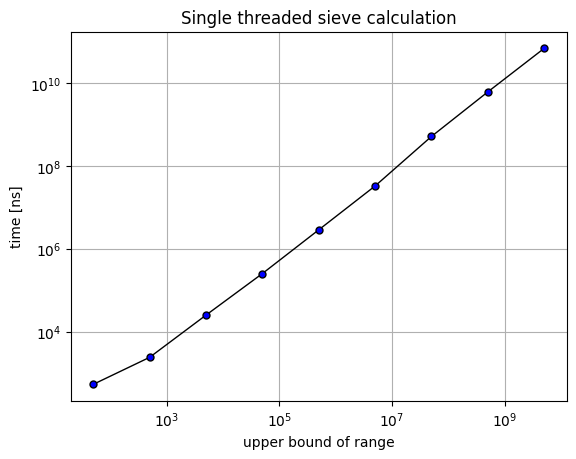

          5e+01          5e+02          5e+03          5e+04          5e+05          5e+06          5e+07          5e+08          5e+09
        0.001ms        0.002ms        0.025ms        0.253ms        2.874ms       32.847ms      513.915ms     6099.101ms    68528.212ms


In [127]:
avg_times = calculate_times(1)

x_s = avg_times.keys()
y_s = avg_times.values()

plt.title("Single threaded sieve calculation")
plt.yscale("log")
plt.ylabel("time [ns]")
plt.xscale("log")
plt.xlabel("upper bound of range")
plt.grid(True)
plt.plot(x_s, y_s, color='black', linewidth=1, marker='o', markerfacecolor='blue', markeredgewidth=1, markersize=5)

plt.show()

for n in avg_times.keys():
    print(f"{n:15.0e}", sep="", end="")
print()
for time in avg_times.values():
    print(f"{time / 1000000:13.3f}ms", sep="", end="")
print()

Na podstawie wyników można zauważyć, że czas wykonywania programu (czas inicjalizacji danych + czas obliczeń) jest liniowy względem granicy obszaru przesiewania. Obliczanie liczb w granicy _4.37\*10<sup>9</sup>_ zajmuje już minutę czasu — a rząd wielkości czasu obliczeń rośnie wprost proporcjonalnie do granicy przesiewania — co sprawia że algorytm ten przestaje być przydatny dla dużych liczb.

## 2. Algorytm współbieżny.

Sito Eratosthenesa ze względu na swoją specyfikę, jest algorytmem trudnym w modyfikacji na algorytm współbieżny. Standardowym podziałem pracy jest w tym przypadku podział obszaru przesiewania na mniejsze zakresy, które dostępne są tylko dla przeliczających je wątków — eliminuje to kosztowną czasowo synchronizację zasobów. Głównym problemem jest tu wybieranie liczb do wykreślania - wszystkie wątki po wykreśleniu liczby pierwszej _x_, muszą czekać aż wątek odpowiedzialny za zakres w którym znajduje się liczba _x+1_ tą liczbę znajdzie — to z kolei z powrotem wprowadza potrzebę synchronizacji. Aby całkowicie wyeliminować ten problem, zakres w którym znajdują się liczby wykreślane — _0..sqrt(N)_ — należy wstępnie przesiać na jednym wątku.

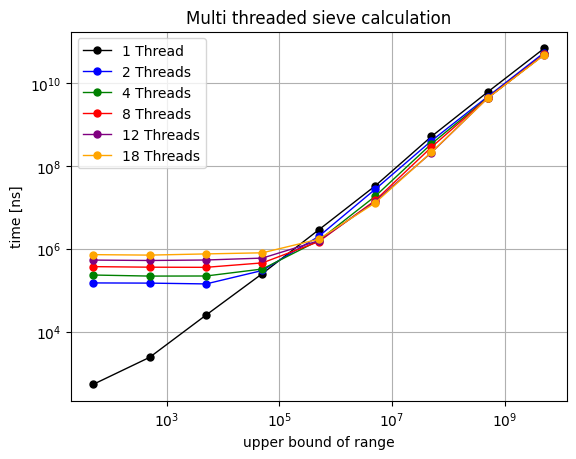

              e          5e+01          5e+02          5e+03          5e+04          5e+05          5e+06          5e+07          5e+08          5e+09
          1 thr        0.001ms        0.002ms        0.025ms        0.253ms        2.874ms       32.847ms      513.915ms     6099.101ms    68528.212ms
          2 thr        0.151ms        0.149ms        0.142ms        0.301ms        1.996ms       27.215ms      403.321ms     4714.576ms    53841.506ms
          4 thr        0.234ms        0.220ms        0.221ms        0.326ms        1.589ms       18.456ms      341.866ms     4406.475ms    48722.686ms
          8 thr        0.372ms        0.361ms        0.358ms        0.458ms        1.494ms       14.653ms      283.695ms     4373.567ms    49320.550ms
         12 thr        0.535ms        0.523ms        0.538ms        0.598ms        1.570ms       13.845ms      209.547ms     4382.053ms    48587.548ms
         18 thr        0.725ms        0.706ms        0.754ms        0.802ms        1.707ms    

In [128]:
thread_counts = [2, 4, 8, 12, 18]
thread_colors = ["blue", "green", "red", "purple", "orange"]

thread_avg_times = {i: calculate_times(i) for i in thread_counts}

plt.title("Multi threaded sieve calculation")
plt.yscale("log")
plt.ylabel("time [ns]")
plt.xscale("log")
plt.xlabel("upper bound of range")
plt.grid(True)
x_s = avg_times.keys()
y_s = avg_times.values()
plt.plot(x_s, y_s, color="black", linewidth=1, marker="o", markerfacecolor="black", markeredgewidth=1, markersize=5,label="1 Thread")

for i, t_c in enumerate(thread_avg_times.keys()):
    x_s = thread_avg_times[t_c].keys()
    y_s = thread_avg_times[t_c].values()
    colr = thread_colors[i]
    plt.plot(x_s, y_s, color=colr, linewidth=1, marker="o", markerfacecolor=colr, markeredgewidth=1, markersize=5, label="{} Threads".format(t_c))

plt.legend()
plt.show()

th_avg_times = {1: avg_times} | thread_avg_times

print(f"{0xe:15x}", sep="", end="")
for n in avg_times.keys():
    print(f"{n:15.0e}", sep="", end="")
print()
for threads, times in th_avg_times.items():
    print(f"{threads:11d} thr", sep="", end="")
    for time in times.values():
        print(f"{time / 1000000:13.3f}ms", sep="", end="")
    print()

Wyniki obliczeń nie pozostawiają złudzeń, że algorytm sita Eratosthenesa jest faktycznie algorytmem odpornym na modyfikacje celem wprowadzenia współbieżności — dla krzywych prezentujących wersje z podziałem na wątki można zauważyć dwa przedziały:
- przedział "przed odbiciem" — jest to przedział, w którym czas wykonania jest liniowy-stały na dużej części zakresu — co spowodowane jest ogromnymi kosztami czasowymi związanymi z obsługą wątków,
- przedział "po odbiciu" - zaczyna się on mniej-więcej pomiędzy _1\*10<sup>5</sup>..2\*10<sup>5</sup>_ — jest to obszar w którym algorytm współbieżny przedstawia podobną zależność czasową względem granicy obszaru, jak algorytm jednowątkowy, jest on jednak szybszy od niego o mniej więcej stały czas - co oznacza że zyski choć występują, są jednak obarczone dużymi spowolnieniami, najprawdopodobniej w miejscach wywołań funkcji systemu operacyjnego. Dodatkowo w przedziale _5\*10<sup>8</sup>..5\*10<sup>9</sup>_, czas wykonywania zdaje się dążyć do niezależności od ilości wprowadzonych wątków - co oznacza że osiągany jest próg prawa Amdahl'a.

### Przemyślenia

Jakiekolwiek próby przyspieszenia algorytmu sita przynoszą niewielkie skutki, lub wręcz prowadzą do większych szkód:
- optymalizacja _liczb parzystych_ — pominięcie liczb parzystych efektywnie prowadzi do pominięcia jednego obrotu pętli przesiewającej (po pętla sprawdza czy liczba na pewno jest pierwsza przed wykreślaniem), oraz zmniejszenia o połowę jednego warunku (sprawdzającego pierwszeństwo). W praktyce zastosowanie tej metody przy kilku testowych zestawów małych danych dało zyski nie przekraczające _5%_ (a zanikające wraz ze zwiększaniem granicy przedziału), w zamian za skomplikowanie kodu sita.
- optymalizacja _6n±1_ — wykorzystanie faktu, że wszystkie liczby pierwsze (_⩾5_) spełniają wspomnianą zależność — wstępne wykreślenie liczb które tej zależności nie spełniają daje niewielki, statyczny zysk czasu (przy znacznym skomplikowaniu kodu i wielu gałęzi warunkowych). Dodatkowe pomijanie liczb wykreślonych wymaga obliczeń zajmujących mniej-więcej taki sam czas, jak zwyczajnie wykreślanie ich ponownie.
- zmniejszenie przedziału przekalkulowanego (_0..sqrt(N)*a%_) — w tym przypadku jakiekolwiek zyski czasowe są z góry skreślone, ponieważ prawdopodobieństwo niespójności danych rośnie eksponencjalnie względem zmniejszenia przedziału, a ochrona przez wprowadzenie synchronizacji powoduje zwiększenie czasu względem wartości wyjściowych.